## Packages & helper functions

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pymongo import MongoClient

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix

In [12]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

In [13]:
def plot_cm(y_true, y_pred, figsize=(6,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

## 1 - Prepare data

In [14]:
data = pd.read_csv('raw_data.csv')
data.head(10)

,content,category
0,Võ sĩ MMA bị knock-out lạ kỳ vì... 'đụng đầu' ...,Thể thao
1,"Thi đấu từ máy bay ở độ cao 6.096m, ngôi sao 6...",Thể thao
2,Tay đua 19 tuổi Jason Dupasquier qua đời sau t...,Thể thao
3,"Giận liên đoàn, CĐV Indonesia không vào sân cổ...",Thể thao
4,"Võ sĩ hạng nặng đánh nhau trên sàn đấu, khán g...",Thể thao
5,"Duy Mạnh, Đình Trọng, Minh Vương đã bình phục ...",Thể thao
6,Vòng đấu cuối Giải ngoại hạng Anh (Premier Lea...,Thể thao
7,Đội tuyển Việt Nam tiếp tục xét nghiệm COVID-1...,Thể thao
8,Video: Thống kê và phong độ của ba thủ môn đội...,Thể thao
9,HLV Nishino 'hài lòng' dù đội tuyển Thái Lan t...,Thể thao


In [15]:
data.groupby('category').size()

category
Công nghệ    50
Du lịch      50
Thể thao     50
dtype: int64

## 2 - Apply TF-IDF on text

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['content']).toarray()
vocab = vectorizer.get_feature_names()

In [17]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10672096, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.05204826, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## 3 - Cluster data by k-means

### 3.1. Tìm số clusters tối ưu bằng   Elbow Method

Có tổng cộng 50 bài báo cho mỗi thể loại "Công nghệ" / "Du lịch" / "Thể thao". Bởi vậy, số cluster tối ưu mà chúng ta mong muốn sẽ là 3, cũng là số thể loại.

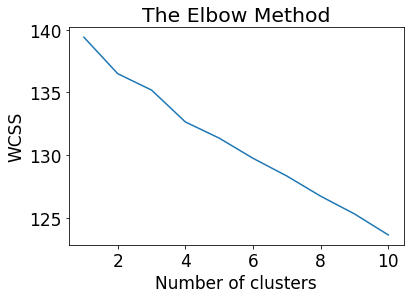

In [21]:
wcss = []
num = 11
for i in range(1,num): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 1, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,num), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Từ đồ thị trên, thật khó để xác định số lượng cluster tối ưu cho tập dữ liệu trên. Tuy nhiên, chúng ta sẽ sử dụng `n_clusters = 3` để giải quyết các bước tiếp theo.

### 3.2. Apply k-means with n_clusters = 3

In [37]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, n_init = 3, random_state = 0)
y_kmeans = kmeans.fit_predict(X)
y_kmeans

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 0,
       2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 1,
       0, 2, 0, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

In [41]:
def categorize(row):
    if row["kmeans_cluster"] == 0:
        return "Công nghệ"
    elif row["kmeans_cluster"] == 1:
        return "Thể thao"
    else:
        return "Du lịch"

data["kmeans_cluster"] = y_kmeans
data["kmeans_label"] = data.apply(lambda row: categorize(row), axis=1)
data

,content,category,kmeans_cluster,kmeans_label
0,Võ sĩ MMA bị knock-out lạ kỳ vì... 'đụng đầu' ...,Thể thao,0,Công nghệ
1,"Thi đấu từ máy bay ở độ cao 6.096m, ngôi sao 6...",Thể thao,0,Công nghệ
2,Tay đua 19 tuổi Jason Dupasquier qua đời sau t...,Thể thao,0,Công nghệ
3,"Giận liên đoàn, CĐV Indonesia không vào sân cổ...",Thể thao,1,Thể thao
4,"Võ sĩ hạng nặng đánh nhau trên sàn đấu, khán g...",Thể thao,0,Công nghệ
...,...,...,...,...
145,"Du khách vội vàng hủy tour, các công ty du lịc...",Du lịch,2,Du lịch
146,Đại sứ Ukraine ở Thái Lan bất ngờ qua đời TTO ...,Du lịch,0,Công nghệ
147,Khách đến Đà Nẵng dịp lễ 30-4 và 1-5 chỉ đạt 5...,Du lịch,2,Du lịch
148,Liên kết vùng để kích cầu du lịch TTO - Chiều ...,Du lịch,2,Du lịch


In [42]:
confusion_matrix(data["category"], data["kmeans_label"])

array([[44,  0,  6],
       [20, 27,  3],
       [14,  0, 36]])

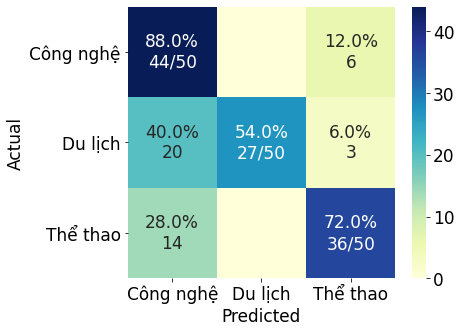

In [43]:
plot_cm(data["category"], data["kmeans_label"])